In [1]:
import numpy as np
from scipy.stats import linregress
import pylab
import pynbody
from scipy.interpolate  import griddata
from astropy.table import Table
import astropy.constants as co
import astropy.units as u
from licplot import lic_internal
import matplotlib.pyplot as plt
from matplotlib import rc, colors
from matplotlib import ticker, cm
import matplotlib.animation as animation
from matplotlib.artist import Artist
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.units as u
import astropy.constants as con
from michaels_functions import center_and_r_vir, remove_bulk_velocity, read_unit_from_info
from michaels_functions import s2, scrit, eff, a_stoa_m, s2m, scritm, effm, vec_transform
from read_ramses_cooling import *
from CR_functions import *


%matplotlib inline

In [2]:
pynbody.__path__

['/home/st9792/.conda/envs/myenv/lib/python3.9/site-packages/pynbody']

## Calculating galaxy properties:

In [3]:
# New SF model data setting up
path = "output_00"
output='106'
data = pynbody.load(path + output)
data.physical_units()
omega_b, omega_m, unit_l, unit_d, unit_t = read_unit_from_info(data)

print(data.properties)
print(data.properties['time'].in_units('Myr'))

{'a': 1.0, 'omegaM0': 1.0, 'omegaL0': 0.0, 'h': 0.01, 'boxsize': Unit("3.20e+02 kpc"), 'time': Unit("1.44e+00 kpc s km**-1")}
1406.3477550069247


In [1]:
!cat ~/.pynbodyrc

# DO NOT alter this file directly
#
# If you want to override options, either create a local copy called
# config.ini in the directory where pynbody is installed, create a local
# copy called .pynbodyrc in your home directory, or a local copy called
# config.ini in the directory where you are running pynbody.

[general]
verbose: False
snap-class-priority: RamsesSnap, GrafICSnap, NchiladaSnap, GadgetSnap, EagleLikeHDFSnap, GadgetHDFSnap, SubFindHDFSnap, TipsySnap, AsciiSnap
halo-class-priority: GrpCatalogue, AmigaGrpCatalogue, RockstarIntermediateCatalogue, RockstarCatalogue, AHFCatalogue, SubfindCatalogue, NewAdaptaHOPCatalogue, AdaptaHOPCatalogue, HOPCatalogue, Gadget4SubfindHDFCatalogue, ArepoSubfindHDFCatalogue

centering-scheme: ssc

threading: True
number_of_threads: -1
# -1 above indicates to detect the number of processors

gravity_calculation_mode: direct_omp

disk-fit-function: expsech

# number of points to use in cosmological function interpolations e.g. t->a transformations

In [7]:
unit_v=unit_l/unit_t #cm/s
unit_b = np.sqrt(4*np.pi*unit_d)*unit_v #Gaussian units
gamma = 5./3.

data.gas['sigma1d'] = pynbody.array.SimArray(np.sqrt(2/3*data.gas['scalar_01'])*unit_v/1e5, 
                                             units='km s**-1')
data.gas['c_s'] = np.sqrt(gamma * data.gas['p'] / data.gas['rho'])
data.gas['M_s'] = data.gas['sigma1d'] / data.gas['c_s'].in_units('km s**-1')

# Magnetic field - cartesian components
data.gas['B_xc'] = 0.5 * (data.gas['B_x_left'] + data.gas['B_x_right']) * unit_b
data.gas['B_yc'] = 0.5 * (data.gas['B_y_left'] + data.gas['B_y_right']) * unit_b
data.gas['B_zc'] = 0.5 * (data.gas['B_z_left'] + data.gas['B_z_right']) * unit_b
data.gas['B2'] = data.gas['B_xc']**2 + data.gas['B_yc']**2 + data.gas['B_zc']**2
data.gas['B_norm'] = np.sqrt(data.gas['B2'])
# conversion to microGauss
data.gas['Bx_uG']=data.gas['B_xc'] * 1e6
data.gas['By_uG']=data.gas['B_yc'] * 1e6
data.gas['Bz_uG']=data.gas['B_zc'] * 1e6
data.gas['B_norm_uG'] = data.gas['B_norm'] * 1e6
data.gas['Bx_norm_uG']=np.abs(data.gas['Bx_uG'])
data.gas['By_norm_uG']=np.abs(data.gas['By_uG'])
data.gas['Bz_norm_uG']=np.abs(data.gas['Bz_uG'])

# Magnetic field - cylindrical components
data.gas['Brxy']=(data.gas['B_xc']*data.gas['x'].in_units('cm') + (data.gas['B_yc']*data.gas['y'].in_units('cm')))/data.gas['rxy'].in_units('cm')
data.gas['Btxy']=(data.gas['B_yc']*data.gas['x'].in_units('cm') - (data.gas['B_xc']*data.gas['y'].in_units('cm')))/data.gas['rxy'].in_units('cm')
# conversion to microGauss
data.gas['Brxy_uG'] = data.gas['Brxy'] * 1e6
data.gas['Btxy_uG'] = data.gas['Btxy'] * 1e6
data.gas['Bz_uG'] = data.gas['B_zc'] * 1e6

#Alvenic speed & beta values
data.gas['v_a'] = pynbody.array.SimArray(data.gas['B_norm'] / np.sqrt(4.*np.pi*data.gas['rho'].in_units('g cm**-3')), 
                                         units='cm s**-1')
data.gas['beta'] = (data.gas['c_s'].in_units('cm s**-1') / data.gas['v_a'])**2.

# convert everything to cgs units for computing alpha_virs and efficiencies
rho = data.gas['rho'].in_units('g cm**-3').view(type=np.ndarray)
dx = data.gas['smooth'].in_units('cm').view(type=np.ndarray)
G = float(pynbody.array.SimArray(6.67e-8, units='cm**3 g**-1 s**-2'))
c_s = data.gas['c_s'].in_units('cm s**-1').view(type=np.ndarray)
M_s = data.gas['M_s'].view(type=np.ndarray)
beta = data.gas['beta'].view(type=np.ndarray)

#Sonic/magnetic alpha_vir and efficiencies
data.gas['alpha_vir_s'] = (15. / np.pi) * (c_s**2. / (G * rho * dx**2.)) * (1. + M_s**2.)
data.gas['alpha_vir_m'] = a_stoa_m(data.gas['alpha_vir_s'].view(type=np.ndarray), 
                                   data.gas['M_s'].view(type=np.ndarray), 
                                   data.gas['beta'].view(type=np.ndarray))
data.gas['eff_s'] = eff(data.gas['alpha_vir_s'].view(type=np.ndarray), 
                        data.gas['M_s'].view(type=np.ndarray))
data.gas['eff_m'] = effm(data.gas['alpha_vir_s'].view(type=np.ndarray), 
                         data.gas['M_s'].view(type=np.ndarray), 
                         data.gas['beta'].view(type=np.ndarray))

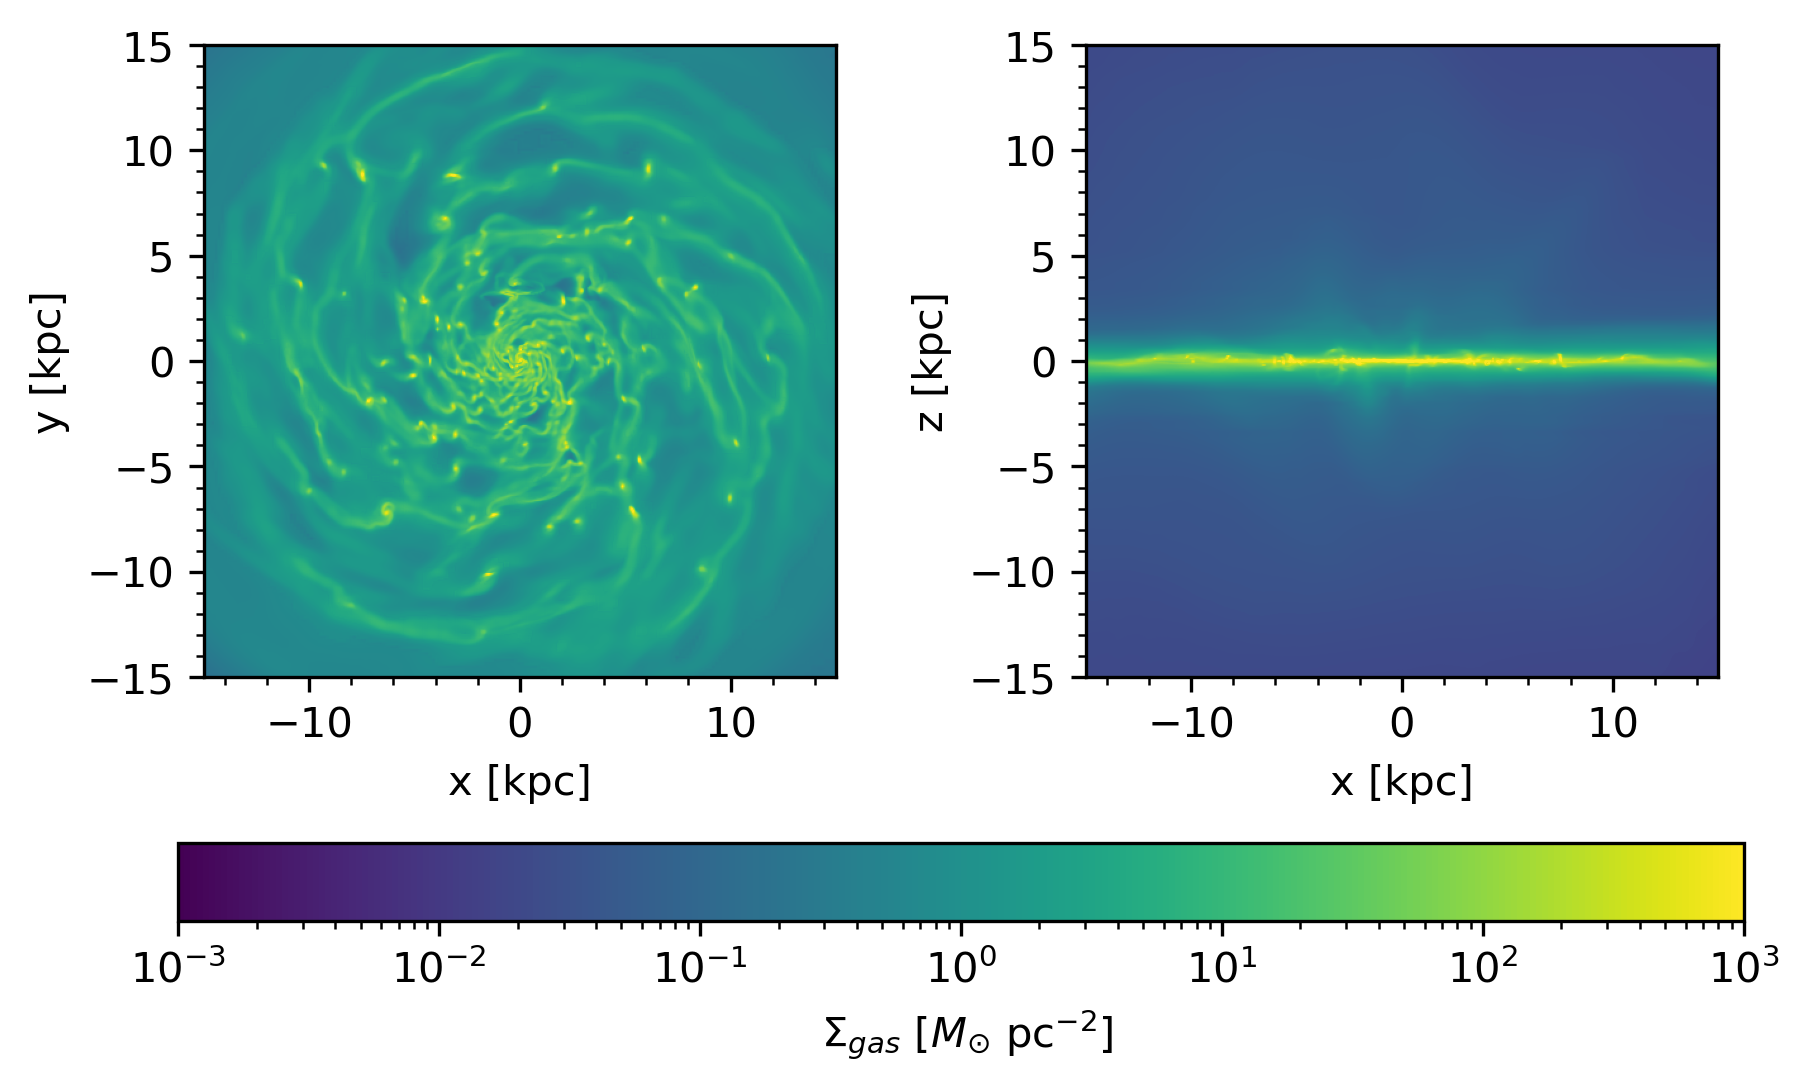

In [10]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)

with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='rho', units='Msol pc**-2', width="%f kpc"%(30), ret_im=True,
                        log=True, resolution=500, vmin=1e-3, vmax=1e3, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='rho', units='Msol pc**-2', width="%f kpc"%(30), ret_im=True,
                        log=True, resolution=500, vmin=1e-3, vmax=1e3, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0,ax=axs, location='bottom', label=r" $\Sigma_{gas}$ $[M_{\odot}~\mathrm{pc}^{-2}]$")
plt.show()

In [11]:
# Calculate alfven mach number:

v_A = data.gas['v_a'].in_units('cm s**-1').view(type=np.ndarray)
M_A0 = data.gas['c_s'].in_units('cm s**-1').view(type=np.ndarray) * data.gas['M_s'] / data.gas['v_a'].in_units('cm s**-1').view(type=np.ndarray)
data.gas['M_A0'] = pynbody.array.SimArray(M_A0)


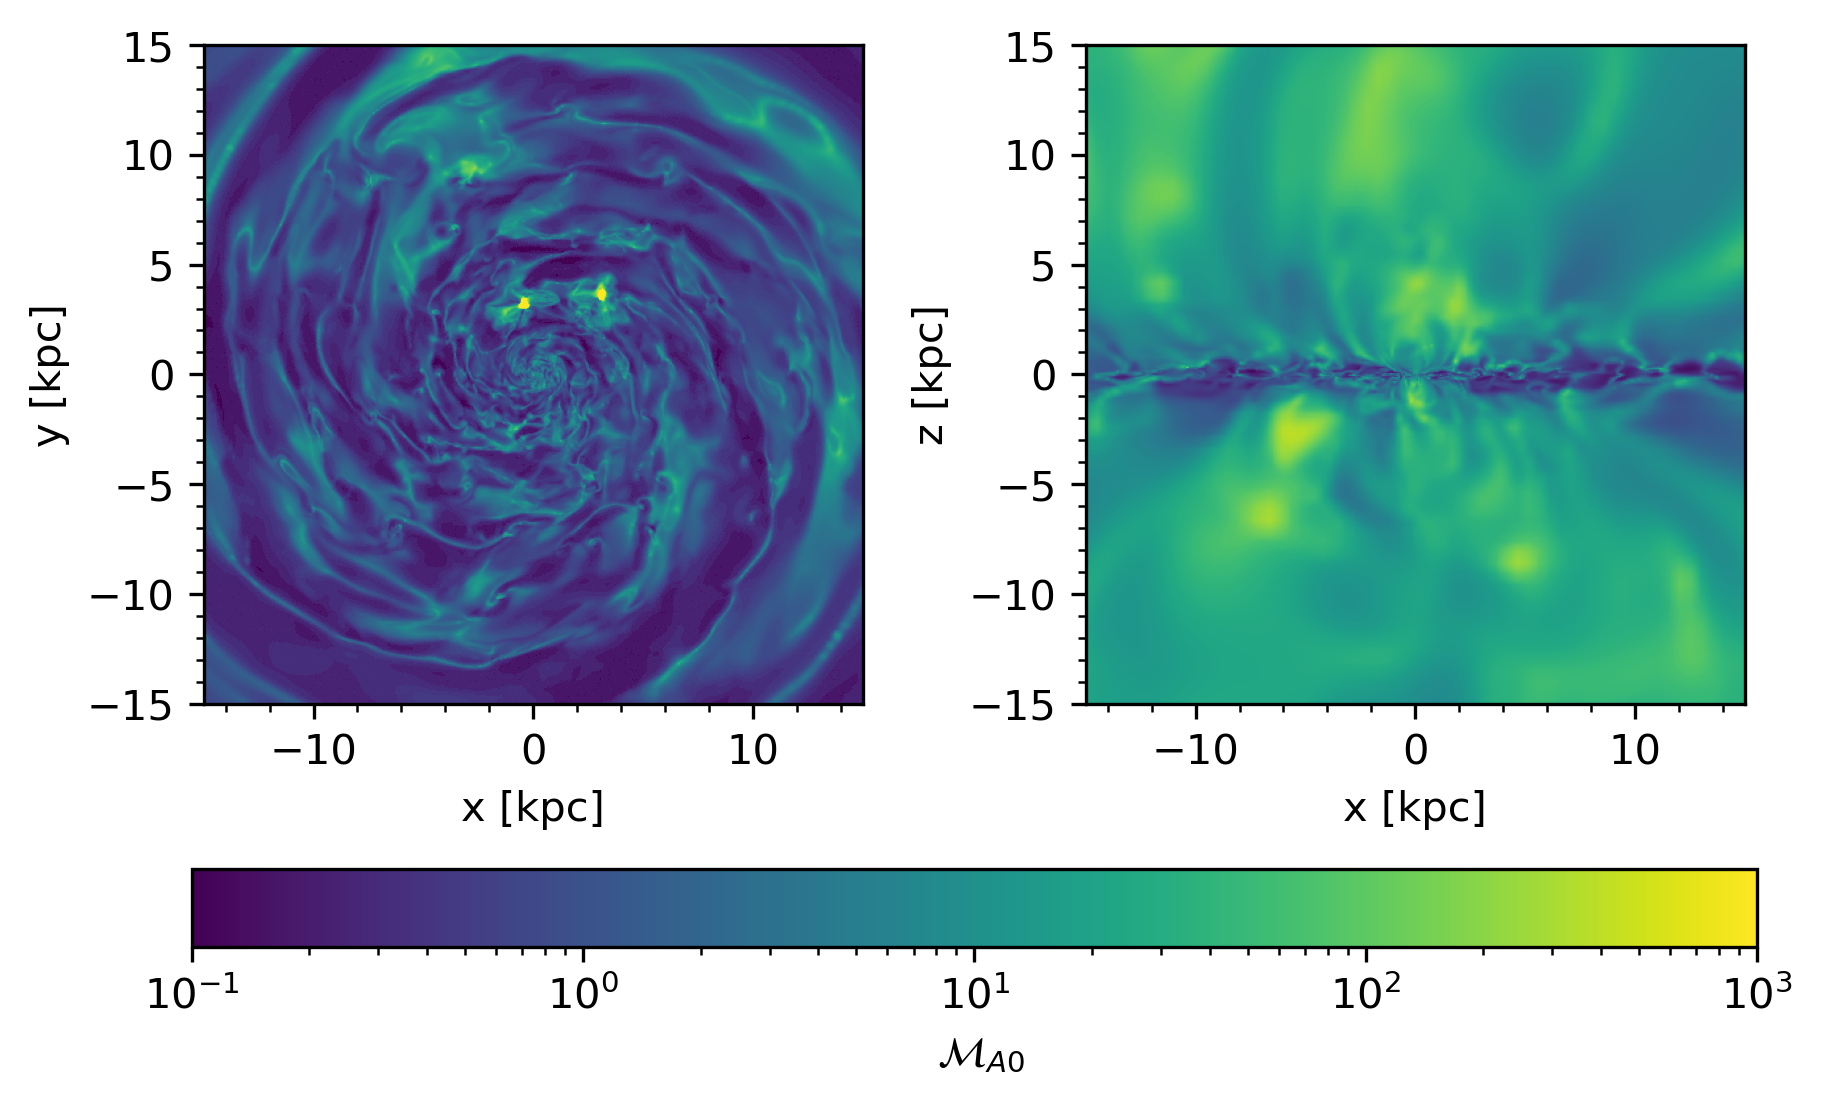

In [12]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)

with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='M_A0', width="%f kpc"%(30), ret_im=True,
                        log=True, vmin=0.1, vmax=1e3, resolution=500, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='M_A0', width="%f kpc"%(30), ret_im=True,
                        log=True, vmin=0.1, vmax=1e3, resolution=500, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0, ax=axs, location='bottom', label=r" $\mathcal{M}_{A0}$")
plt.show()

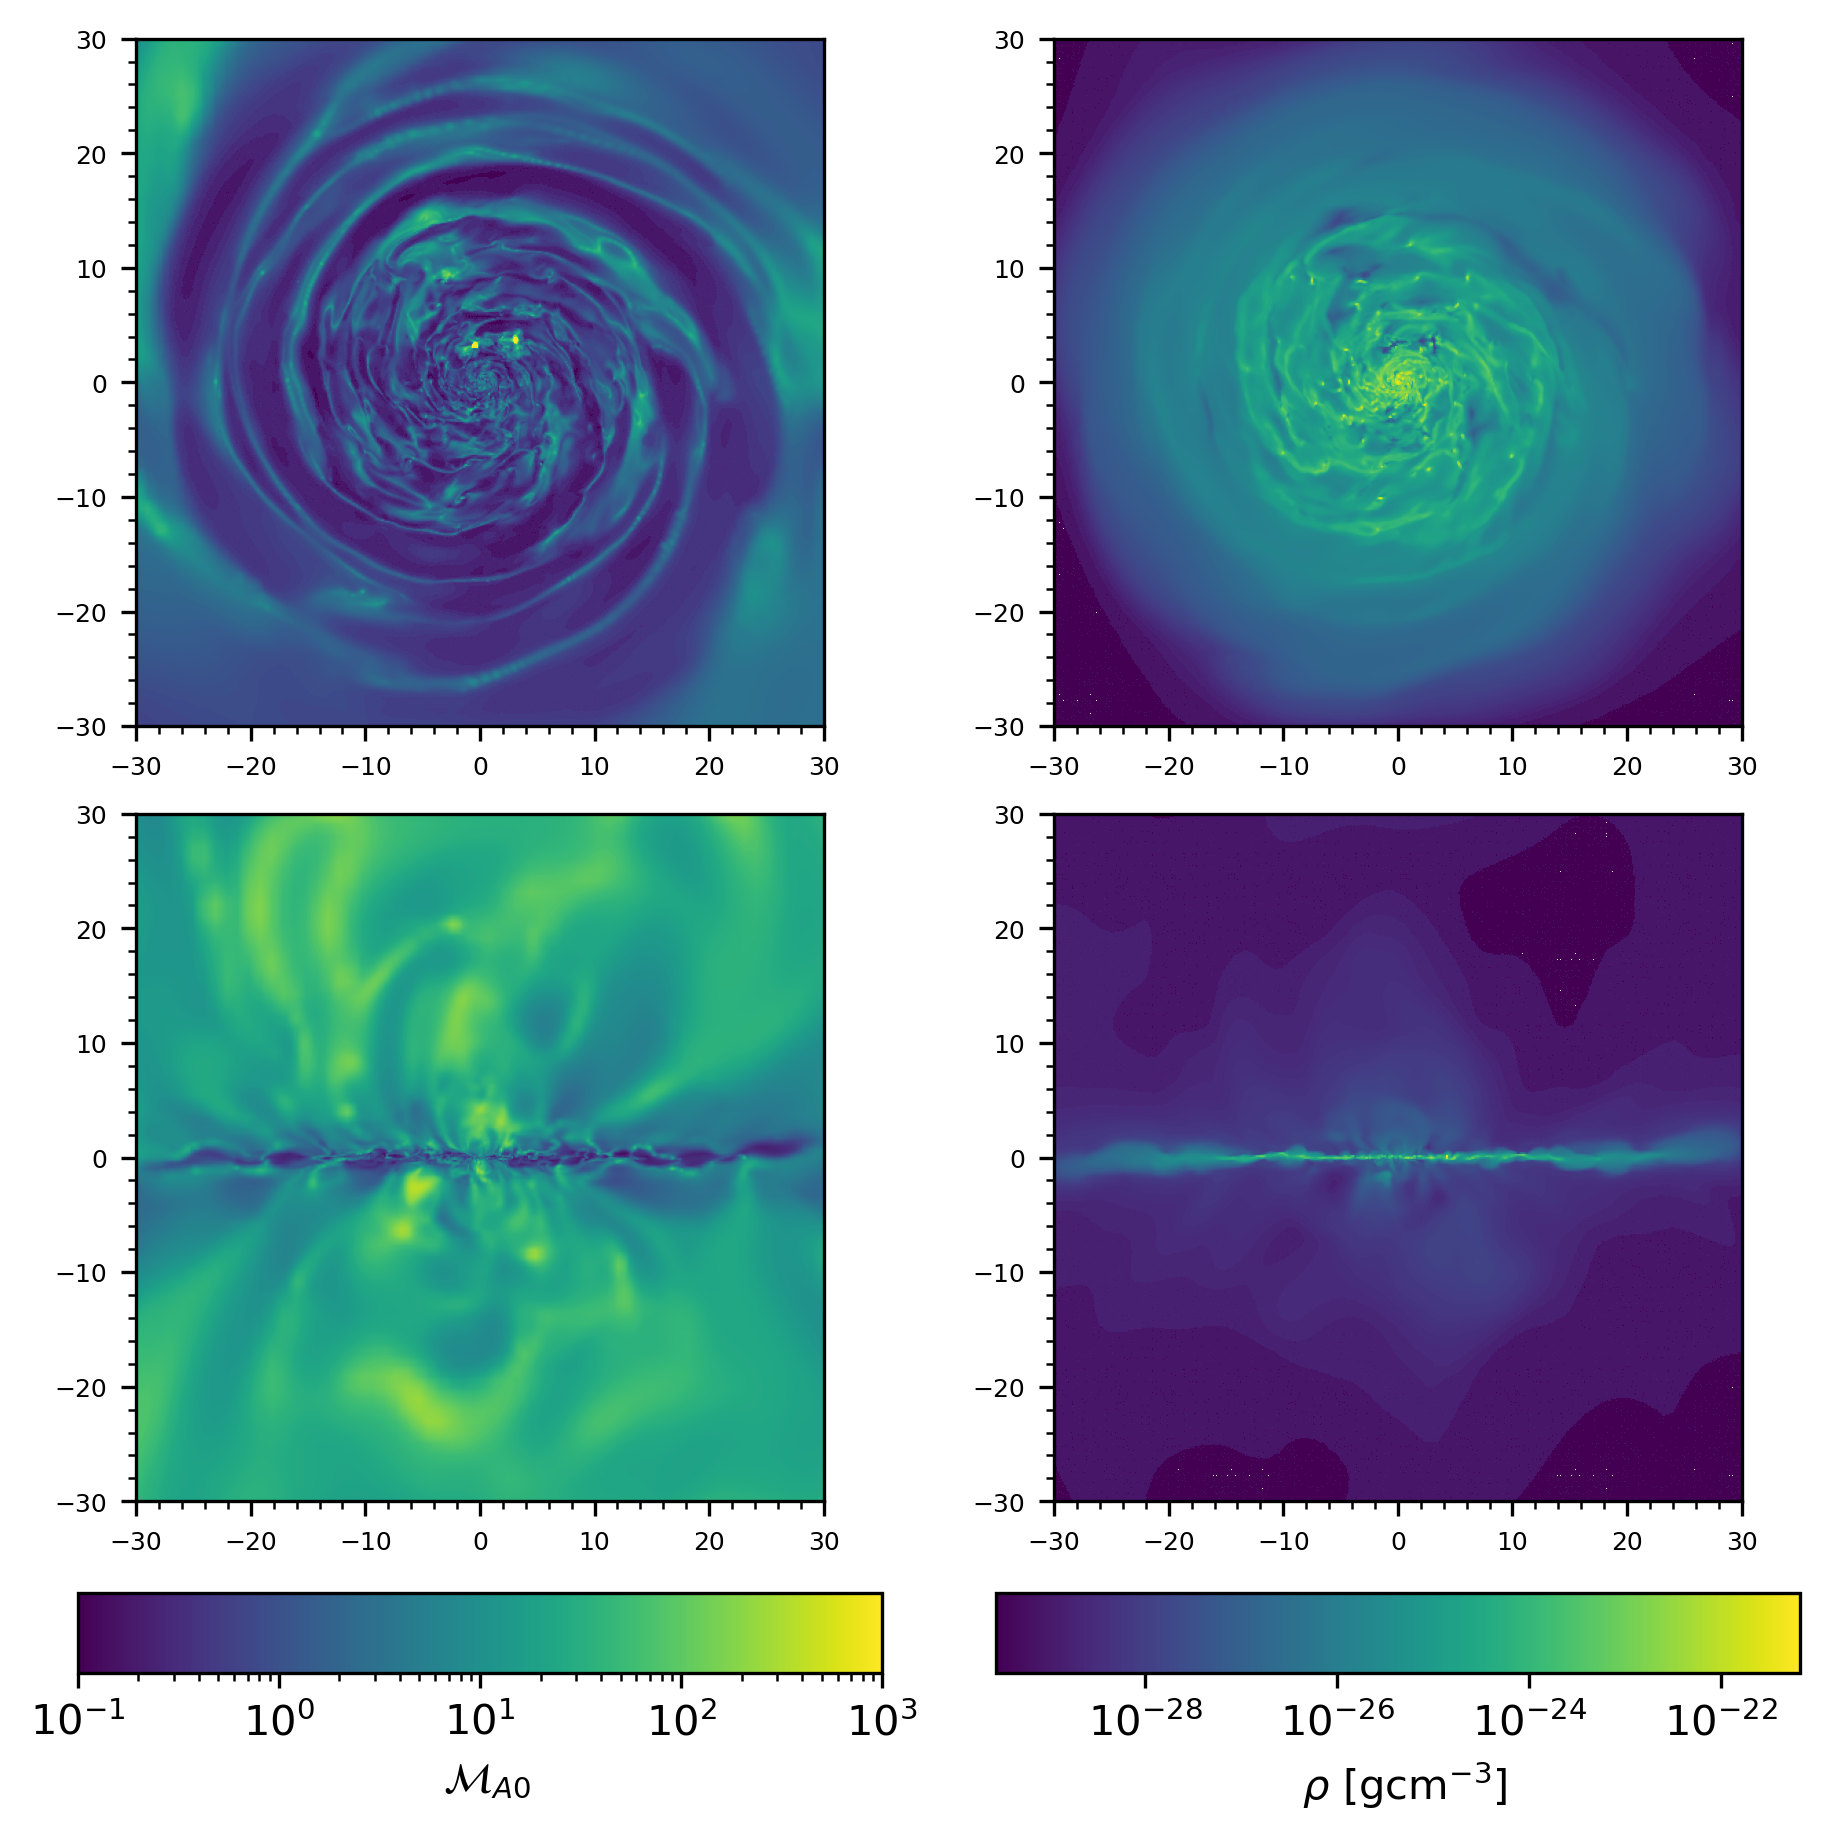

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), constrained_layout=True, dpi=300)

with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='M_A0', width="%f kpc"%(60), ret_im=True,
                        log=True, vmin=0.1, vmax=1e3, resolution=500, cmap="viridis",    
                        subplot=axs[0,0],show_cbar=False)
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas, qty='M_A0', width="%f kpc"%(60), ret_im=True,
                        log=True, vmin=0.1, vmax=1e3, resolution=500, cmap="viridis",    
                        subplot=axs[1,0],show_cbar=False)
    
with pynbody.analysis.angmom.faceon(data):
    im2 = pynbody.plot.image(data.gas, qty='rho', units='g cm**-3', width="%f kpc"%(60), ret_im=True,
                        log=True, resolution=500, cmap="viridis",    
                        subplot=axs[0,1],show_cbar=False)
with pynbody.analysis.angmom.sideon(data):
    im3 = pynbody.plot.image(data.gas, qty='rho', units='g cm**-3', width="%f kpc"%(60), ret_im=True,
                        log=True, resolution=500, cmap="viridis",    
                        subplot=axs[1,1],show_cbar=False)
    
for ax in axs.flatten():
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(labelsize=6)

plt.colorbar(im1, ax=axs[1,0], aspect=10, location='bottom', label=r" $\mathcal{M}_{A0}$")
plt.colorbar(im3, ax=axs[1,1], aspect=10, location='bottom', label=r" $\rho~[\rm{gcm}^{-3}]$")
plt.show()

Text(0, 0.5, 'log$_{10}(\\mathcal{M}_{A0})$')

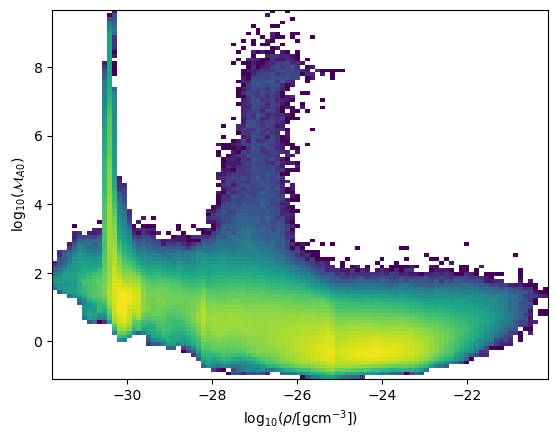

In [14]:
vals, binx, biny, _ = plt.hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['M_A0']), bins=100, norm=LogNorm());
vminrho = 10**binx.min()
vmaxrho = 10**binx.max()
vminM = 10**biny.min()
vmaxM = 10**biny.max()
plt.xlabel('log$_{10}(\\rho/$[gcm$^{-3}])$')
plt.ylabel('log$_{10}(\mathcal{M}_{A0})$')

Text(0, 0.5, '|B|')

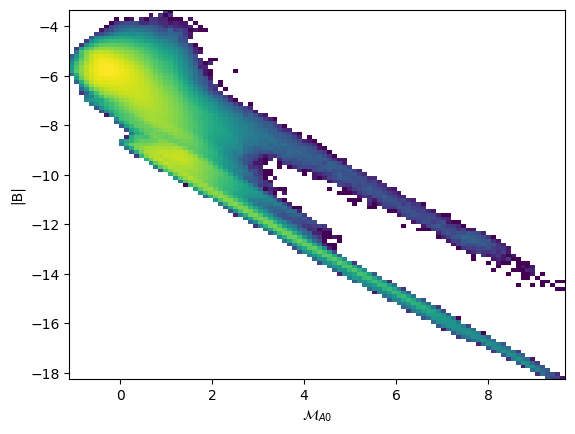

In [15]:
plt.hist2d(np.log10(data.gas['M_A0']), np.log10(data.gas['B_norm']), bins=100, norm=LogNorm());
plt.xlabel('$\mathcal{M}_{A0}$')
plt.ylabel('|B|')

## Looking at just this pillar:


In [44]:
lowerx = -28.25
upperx = -28.25 + 3
lowery = 3.5
uppery = 3.5 + 5.75

Text(0, 0.5, 'log$_{10}(\\mathcal{M}_{A0})$')

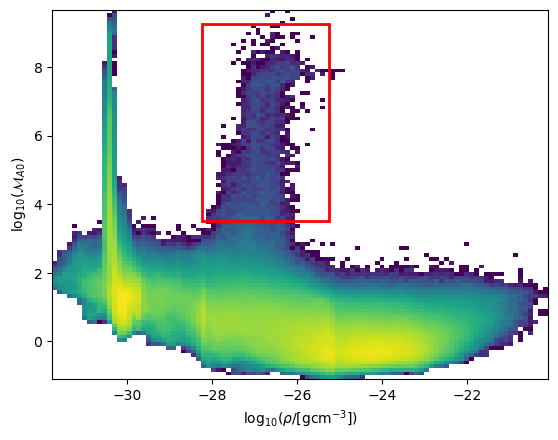

In [45]:
fig, ax = plt.subplots()
vals, binx, biny, _ = plt.hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['M_A0']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((-28.25,3.5), 3, 5.75, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.xlabel('log$_{10}(\\rho/$[gcm$^{-3}])$')
plt.ylabel('log$_{10}(\mathcal{M}_{A0})$')

In [46]:
logM = np.log10(data.gas['M_A0'])
logrho = np.log10(data.gas['rho'].in_units('g cm**-3'))
flag = (logM>lowery)&(logM<uppery)&(logrho>lowerx)&(logrho<upperx)
                                        
dataseg = data.gas[flag]

(-6.0, 6.0)

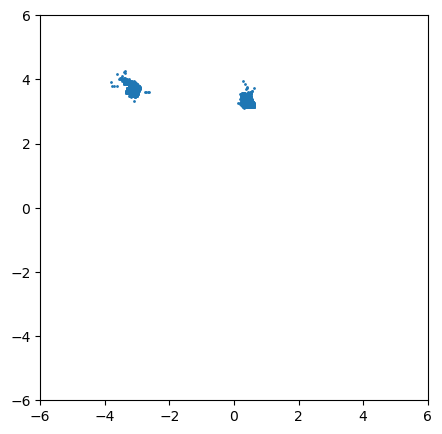

In [68]:
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(dataseg.gas['x']-160, dataseg.gas['y']-160, s=1)
plt.xlim(-6,6)
plt.ylim(-6,6)

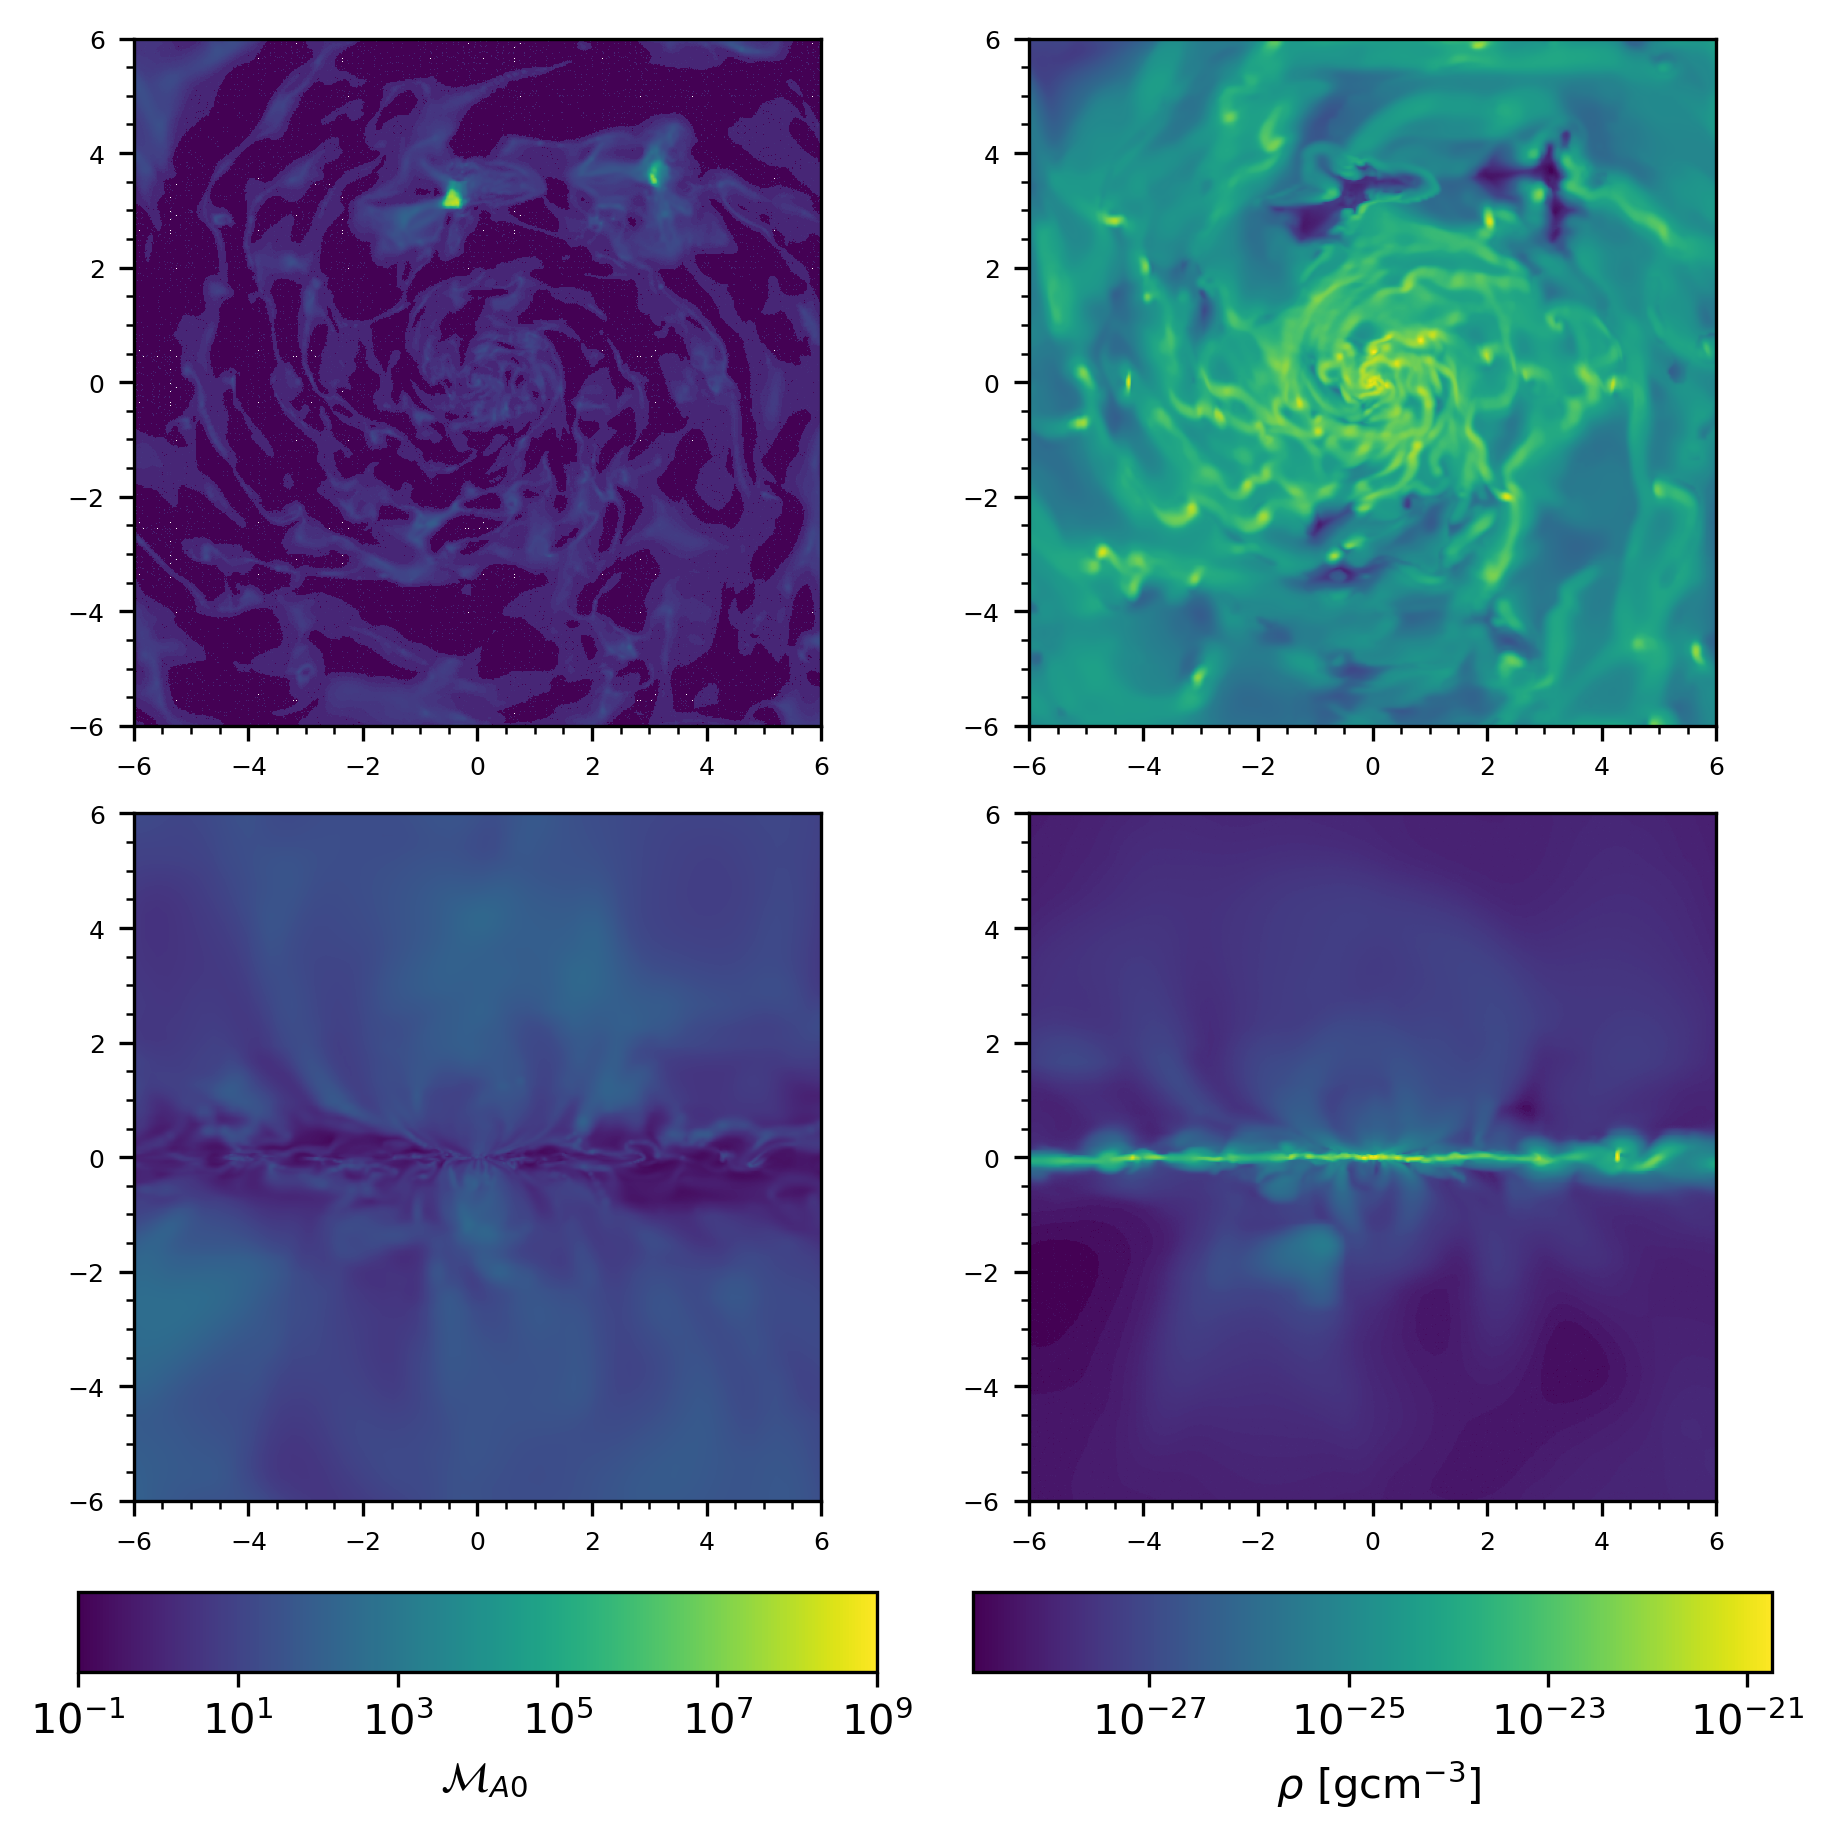

In [49]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), constrained_layout=True, dpi=300)

w = 12

with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='M_A0', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.1, vmax=1e9, resolution=500, cmap="viridis",    
                        subplot=axs[0,0],show_cbar=False)
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas, qty='M_A0', width="%f kpc"%(w), ret_im=True,
                        log=True, vmin=0.1, vmax=1e9, resolution=500, cmap="viridis",    
                        subplot=axs[1,0],show_cbar=False)
    
with pynbody.analysis.angmom.faceon(data):
    im2 = pynbody.plot.image(data.gas, qty='rho', units='g cm**-3', width="%f kpc"%(w), ret_im=True,
                        log=True, resolution=500, cmap="viridis",    
                        subplot=axs[0,1],show_cbar=False)
with pynbody.analysis.angmom.sideon(data):
    im3 = pynbody.plot.image(data.gas, qty='rho', units='g cm**-3', width="%f kpc"%(w), ret_im=True,
                        log=True, resolution=500, cmap="viridis",    
                        subplot=axs[1,1],show_cbar=False)
    
for ax in axs.flatten():
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(labelsize=6)

plt.colorbar(im1, ax=axs[1,0], aspect=10, location='bottom', label=r" $\mathcal{M}_{A0}$")
plt.colorbar(im3, ax=axs[1,1], aspect=10, location='bottom', label=r" $\rho~[\rm{gcm}^{-3}]$")
plt.show()

## That pillar therefore is the two unknown events happening about 4 kpc from the galactic center. Maybe SN explosions?

(-1.110059087078454, 10.0)

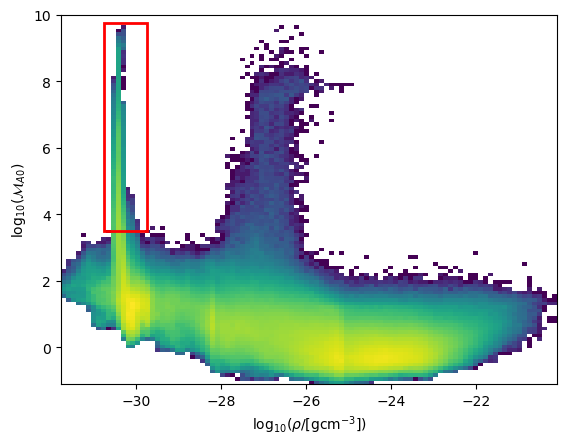

In [71]:
lowerx = -30.75
dx = 1
lowery = 3.5
dy = 6.25

fig, ax = plt.subplots()
vals, binx, biny, _ = plt.hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['M_A0']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.xlabel('log$_{10}(\\rho/$[gcm$^{-3}])$')
plt.ylabel('log$_{10}(\mathcal{M}_{A0})$')
plt.ylim(top=10)

In [72]:
flag = (logrho>lowerx)&(logrho<lowerx+dx)&(logM>lowery)&(logM<lowery+dy)                             
dataseg = data.gas[flag]

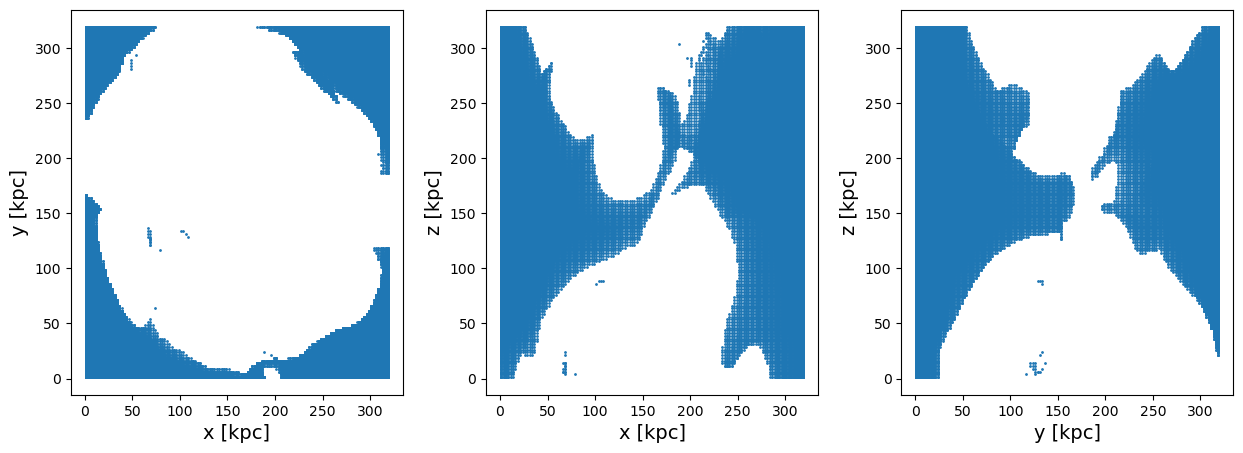

In [73]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(dataseg['x'], dataseg['y'], s=1)
ax[0].set_xlabel('x [kpc]', fontsize=14)
ax[0].set_ylabel('y [kpc]', fontsize=14)
ax[1].scatter(dataseg['x'], dataseg['z'], s=1)
ax[1].set_xlabel('x [kpc]', fontsize=14)
ax[1].set_ylabel('z [kpc]', fontsize=14)
ax[2].scatter(dataseg['y'], dataseg['z'], s=1)
ax[2].set_xlabel('y [kpc]', fontsize=14)
ax[2].set_ylabel('z [kpc]', fontsize=14)
plt.subplots_adjust(wspace=0.25)

### This segment is thus all contained very far away from the galaxy, where the density has dropped off to extremely low values.

(-1.110059087078454, 10.0)

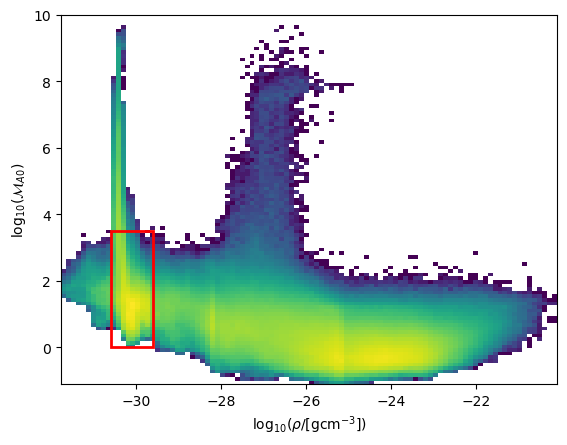

In [27]:
lowerx = -30.6
dx = 1.0
lowery = 0
dy = 3.5

fig, ax = plt.subplots()
vals, binx, biny, _ = plt.hist2d(np.log10(data.gas['rho'].in_units('g cm**-3')), np.log10(data.gas['M_A0']), bins=100, norm=LogNorm());

# Create a Rectangle patch
rect = patches.Rectangle((lowerx,lowery), dx, dy, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.xlabel('log$_{10}(\\rho/$[gcm$^{-3}])$')
plt.ylabel('log$_{10}(\mathcal{M}_{A0})$')
plt.ylim(top=10)

In [28]:
flag = (logrho>lowerx)&(logrho<lowerx+dx)&(logM>lowery)&(logM<lowery+dy)                             
dataseg = data.gas[flag]

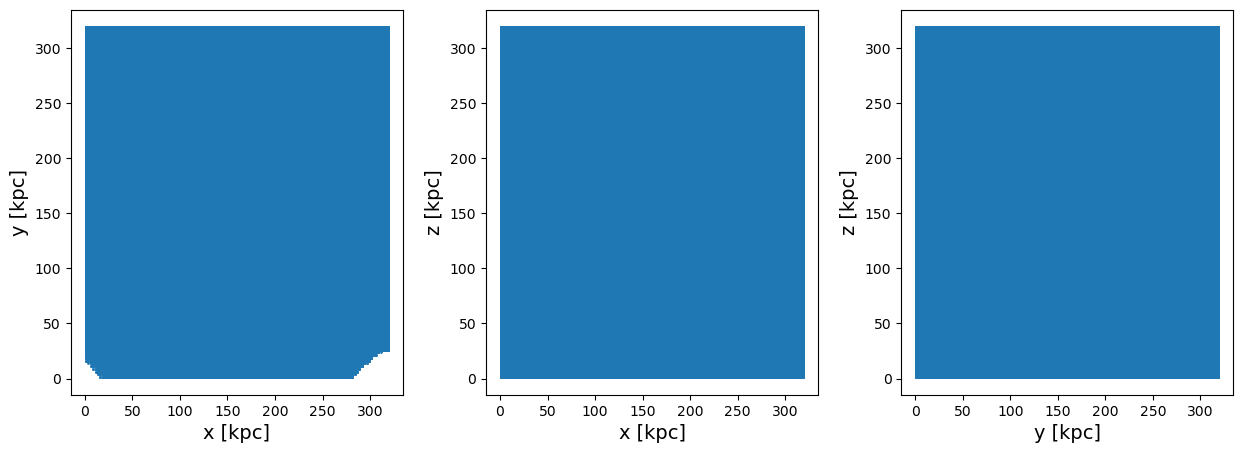

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(dataseg['x'], dataseg['y'], s=1)
ax[0].set_xlabel('x [kpc]', fontsize=14)
ax[0].set_ylabel('y [kpc]', fontsize=14)
ax[1].scatter(dataseg['x'], dataseg['z'], s=1)
ax[1].set_xlabel('x [kpc]', fontsize=14)
ax[1].set_ylabel('z [kpc]', fontsize=14)
ax[2].scatter(dataseg['y'], dataseg['z'], s=1)
ax[2].set_xlabel('y [kpc]', fontsize=14)
ax[2].set_ylabel('z [kpc]', fontsize=14)
plt.subplots_adjust(wspace=0.25)

### This is just a hodge-podge of all over

_______

# Ionization fraction calcs

In [ ]:
from pynbody.analysis.ionfrac import calculate as ionfrac

In [ ]:
chivals = ionfrac(data)
data.gas['chi'] = pynbody.array.SimArray(chivals, units='1.00')

In [ ]:
filename = "output_00106/cooling_00106.out"
c, nH, T2 = rd_cool(filename)

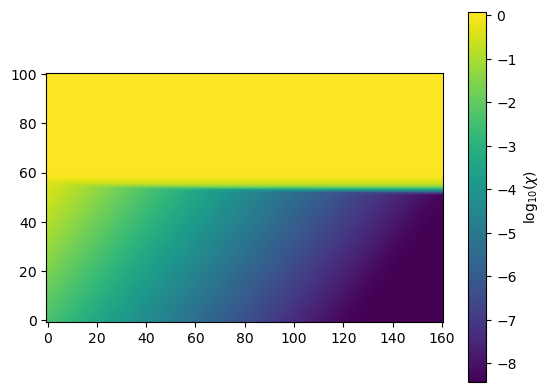

In [ ]:
plt.imshow(c.xion,origin="lower")
plt.colorbar(label='log$_{10}(\chi$)')

In Sampson+(2022), their parameter range is as follows:

"parameter values we sample are...
- $\mathcal{M} \in$ [2, 4, 6, 8, 10]
- $\mathcal{M}_{A0} \in$ [0.1, 0.5, 1, 2, 4, 6, 8, 10]
- $\log_{10}\chi \in$ [−5, −4, −3, −2, −1, 0]

... These values are chosen to capture the diversity of $\mathcal{M}$ and $\mathcal{M}_{A0}$ encountered in the ISM (Tofflemire et al. 2011; Burkhart et al. 2014). We carry out runs with every possible combination of these parameters, for a total of 210 trials"

The parameter space in our snapshot is thus outside of that of this study in all directions. See the histograms below:

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
ax[0,0].hist(data.gas['M_s'], bins=np.logspace(-2.1,2.56,50), histtype='step', color='k', lw=2);
ax[0,0].set_xlabel('$\mathcal{M}_s$', fontsize=16)
ax[0,0].set_ylabel('counts', fontsize=14)
ax[0,0].axvline(2, color='r', label='Sampson+(2022) min', lw=2)
ax[0,0].axvline(10, color='r', ls='--', label='max', lw=2)
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].legend(loc='center left', bbox_to_anchor=(0, 1.1))

ax[0,1].hist(data.gas['M_A0'], bins=np.logspace(-1.5,9.7,50), histtype='step', color='k', lw=2);
ax[0,1].set_xlabel('$\mathcal{M}_{A0}$', fontsize=16)
ax[0,1].axvline(0.1, color='r', lw=2)
ax[0,1].axvline(10, color='r', ls='--', lw=2)
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')

ax[1,0].hist(np.log10(xion), bins=np.linspace(-8.5, 0.064, 50), histtype='step', color='k', lw=2);
ax[1,0].set_xlabel('log$_{10}(\chi)$', fontsize=16)
ax[1,0].set_ylabel('counts', fontsize=14)
ax[1,0].set_yscale('log')
ax[1,0].axvline(-5, color='r', lw=2)
ax[1,0].axvline(0, color='r', ls='--', lw=2)


ax[1,1].hist(data.gas['kratio'], bins=np.logspace(0.03, 4.2, 50), histtype='step', color='k', lw=2);
ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('$k_\parallel/k_\perp$', fontsize=16)
ax[1,1].axvline(1, color='xkcd:bright blue', lw=2, label='Sampson+(2022)\nresult min')
ax[1,1].axvline(1000, color='xkcd:bright blue', ls='--', lw=2, label='max')
ax[1,1].legend(loc=(0.1,0.77), fontsize=9)

plt.subplots_adjust(hspace=0.25)